In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import math

import os
import torch.nn as nn
import torch.nn.functional as F

In [2]:

#data_PATH = "/content/data/"
#log_PATH = os.path.join("/gdrive","My Drive","notebooks", "logs","wgan-gp")
#modelName = "WGAN-gp_DCGAN_without_ln_conference_lsun"

batch_size =64
workers = 2
epochs = 200

latent_size=100

gf_dim = 64
df_dim = 64

in_h = 64
in_w = 64
c_dim = 1

n_critic = 5 # the number of iterations of the critic per generator iteration

learning_rate = 0.0001
beta1=0.5
beta2=0.9

gp_lambda = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

def conv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,bias=False),
        nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
    )
def tconv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
  )
def tconv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def conv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def fc_layer(in_features,out_features):
  return nn.Linear(in_features,out_features)

def fc_bn_layer(in_features,out_features):
  return nn.Sequential(
      nn.Linear(in_features,out_features,bias=False),
      nn.BatchNorm1d(out_features)
  )

def conv_out_size_same(size, stride):
  return int(math.ceil(float(size) / float(stride)))
s_h, s_w = in_h, in_w
s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

print(s_h16, s_w16)
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc_bn_layer1 = fc_bn_layer(latent_size,s_h16*s_w16*gf_dim*8) # 4x4
    self.up_sample_layer2 = tconv_bn_layer(gf_dim*8,gf_dim*4,4,stride=2,padding=1) # 8x8
    self.up_sample_layer3 = tconv_bn_layer(gf_dim*4,gf_dim*2,4,stride=2,padding=1)  #16x16
    self.up_sample_layer4 = tconv_bn_layer(gf_dim*2,gf_dim,4,stride=2,padding=1) #32x32
    self.up_sample_layer5 = tconv_layer(gf_dim,c_dim,4,stride=2,padding=1)  #64x64
    self.tanh = nn.Tanh()
    #self.relu = nn.ReLU()
    #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    #self.drop_neurons = nn.Dropout(p=0.2)
    #self.adjust_channels = nn.Conv2d(gf_dim * 8, gf_dim * 4, kernel_size=1)
    #Convolutional layers to adjust the number of channels
    self.adjust_channels2 = nn.Conv2d(gf_dim * 8, gf_dim * 4, kernel_size=1)
    self.adjust_channels3 = nn.Conv2d(gf_dim * 4, gf_dim * 2, kernel_size=1)
    self.adjust_channels4 = nn.Conv2d(gf_dim * 2, gf_dim, kernel_size=1)
    self.adjust_channels5 = nn.Conv2d(gf_dim, c_dim, kernel_size=1)

    self.gaussian_kernel = nn.Parameter(torch.randn(gf_dim * 8, gf_dim * 8, 3, 3))  # Corrected input channels
    #self.softplus = nn.Softplus() # use this instead of ReLU()
    ##
    ## softplus
    ## Forward pass
  def forward(self, x):
    x1 = self.fc_bn_layer1(x).view(-1, gf_dim * 8, s_h16, s_w16)  # Reshape after fully connected layer
    # Apply Gaussian kernel convolution
    x1 = F.conv2d(x1, self.gaussian_kernel, padding=1)
    #print("x1 size ->", x1.size())
    x2 = F.relu(self.up_sample_layer2(x1))
    #print("x2 size ->", x2.size())
    x3 = F.relu(self.up_sample_layer3(x2))
    #print("x3 size ->", x3.size())
    x4 = F.relu(self.up_sample_layer4(x3))
    #print("x4 size ->", x4.size())
    x5 = F.relu(self.up_sample_layer5(x4))
    #print("x5 size ->", x5.size())
    ## dropout x1

    x2_skip = F.interpolate(x1, scale_factor = 2, mode='nearest')
    x2_skip = self.adjust_channels2(x2_skip)
    x2 = torch.add(x2,x2_skip)

#   64, 128, 16, 16
    #x3_random_noise = self.softplus(torch.randn(x3.size(),device=device))
    x3_skip = F.interpolate(x2, scale_factor = 2, mode='nearest')
    x3_skip = self.adjust_channels3(x3_skip)
    #x3 = torch.add(x3,x3_random_noise)
    x3 = torch.add(x3,x3_skip)
    ## dropout x3

    x4_skip = F.interpolate(x3, scale_factor = 2, mode='nearest')
    x4_skip = self.adjust_channels4(x4_skip)
    x4 = torch.add(x4,x4_skip)

    x5_skip =F.interpolate(x4, scale_factor = 2, mode='nearest')
    x5_skip = self.adjust_channels5(x5_skip)
    x5 = torch.add(x5,x5_skip)
    #print(x1.size(1), x2.size(1))
    # Add skip connections
    return self.tanh(x5)



Random Seed:  3734
4 4


In [3]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models

# Assuming your generator model has the same architecture as 'Generator' class
  # Import your Generator class

#generator = Generator()  # Initialize your generator
generator = torch.load('../wgan_64/gen-7250.pth', map_location=torch.device('cuda'))
generator.eval()  # Set the model to evaluation mode if needed
generator.cuda()


# Generate a batch of fake images

Generator(
  (fc_bn_layer1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sample_layer5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
  (adjust_c

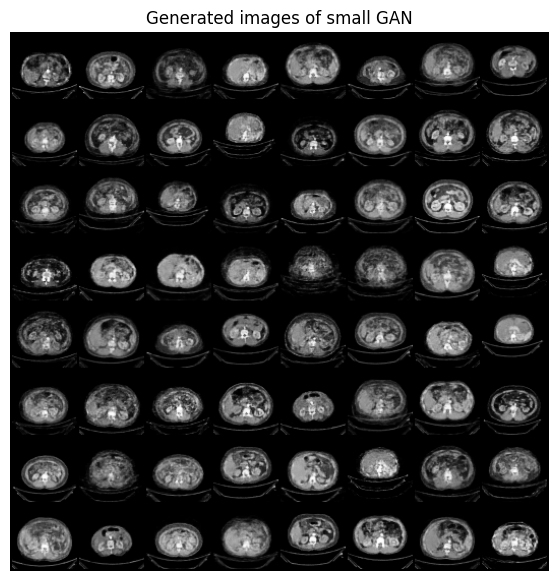

In [23]:
batch_size = 64
z_dim = 100  # Assuming the dimension of the input noise vector
fixed_noise = torch.randn(batch_size, z_dim,device='cuda')  # Generate fixed noise
with torch.no_grad():
    fake_images = generator(fixed_noise).cpu()



# Plot the fake images
plt.figure(figsize=(7, 7))
plt.axis("off")
plt.title("Generated images of small GAN")
plt.imshow(
    np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0))
)
plt.savefig("../visual/64_skip_viz/small_gan_output7.png",dpi=300)
plt.show()


In [20]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: inception_model.fc

# You want to replace the final fully-connected (fc) layer 
# with an identity function layer to cut off the classification
# layer and get a feature extractor
#### START CODE HERE ####
inception_model.fc = nn.Identity()
#### END CODE HERE ####

In [9]:
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: frechet_distance
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    #### START CODE HERE ####
    return torch.norm(mu_x - mu_y, p = 2)**2 + torch.trace(sigma_x + sigma_y - 2*matrix_sqrt(sigma_x@sigma_y))
    #### END CODE HERE ####

In [10]:
import numpy as np
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(64, 64)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        #image = image.resize(self.target_size, Image.LANCZOS)  # Resize image with LANCZOS filter
        if self.transform:
            image = self.transform(image)
        return image


# Define constants
IMAGE_SIZE = (64, 64)
IMAGE_DIR = '../experimental'

# Transformation to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((in_h,in_w)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Create dataset
dataset = CustomDataset(root_dir=IMAGE_DIR, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)
# Function to convert grayscale images to RGB
def convert_to_rgb(grayscale_images):
    return torch.cat([grayscale_images] * 3, dim=1)  #



In [16]:
from tqdm.auto import tqdm

fake_features_list = []
real_features_list = []

generator.eval()

n_samples = 3274


cur_samples = 0


# Function to resize images to the minimum required size for Inception model
def resize_to_min_size(images, min_size=(299, 299)):
    return F.interpolate(images, size=min_size, mode='bicubic', align_corners=False)

with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    for real_example in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
        real_samples = real_example
        real_samples_rgb = convert_to_rgb(real_samples)
        real_samples_resized = resize_to_min_size(real_samples_rgb)  # Resize to minimum required size
        real_features = inception_model(real_samples_resized.to(device)).detach().to('cpu') # Move features to CPU
        real_features_list.append(real_features)

        fake_samples = get_noise(len(real_example), z_dim).to(device)
        fake_samples = preprocess(generator(fake_samples))
        fake_samples_rgb = convert_to_rgb(fake_samples)  # Convert fake samples to RGB
        fake_samples_resized = resize_to_min_size(fake_samples_rgb)  # Resize to minimum required size
        fake_features = inception_model(fake_samples_resized.to(device)).detach().to('cpu')
        fake_features_list.append(fake_features)
        cur_samples += len(real_samples)
        if cur_samples > n_samples:
            break   

# Function to convert grayscale images to RGB
def convert_to_rgb(grayscale_images):
    # Replicate single channel to create three channels
    return grayscale_images.repeat(1, 3, 1, 1)



52it [00:58,  1.12s/it]                        


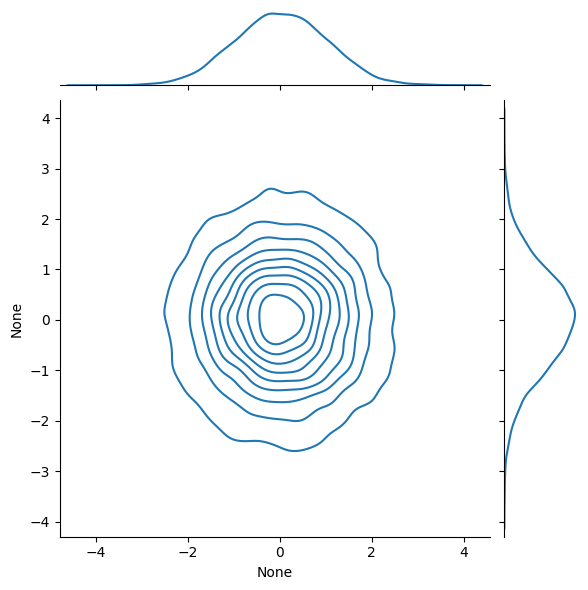

In [17]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

In [18]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Needed as is for autograding
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL

# Calculate the covariance matrix for the fake and real features
# and also calculate the means of the feature over the batch (for each feature dimension mean)
#### START CODE HERE ####
mu_fake = torch.mean(fake_features_all, dim=0)
mu_real = torch.mean(real_features_all, dim=0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)
#### END CODE HERE ####

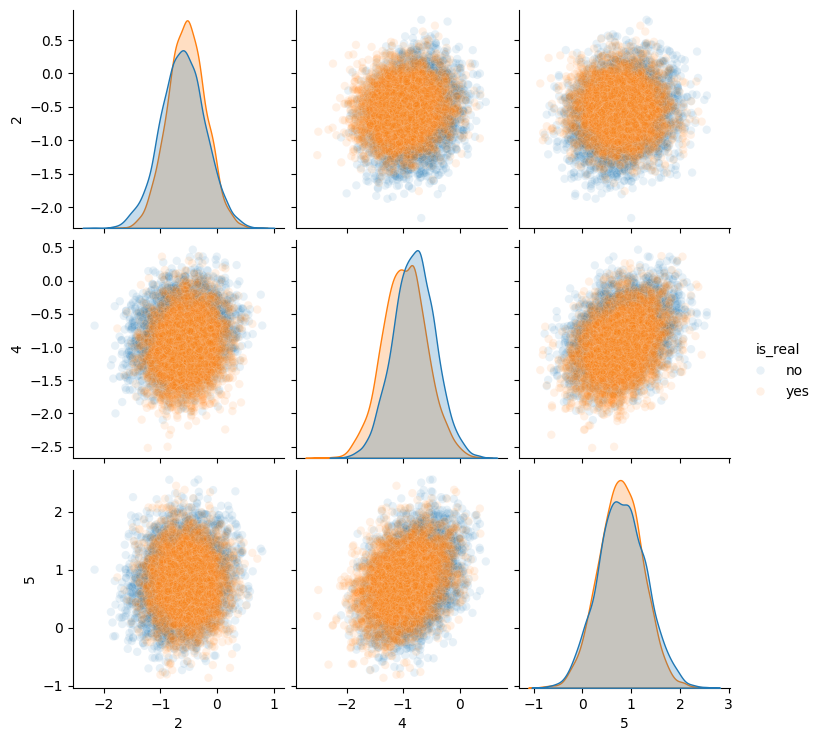

In [19]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(data = df, plot_kws={'alpha': 0.1}, hue='is_real')
plt.show()

In [21]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

264.9432373046875
